# Data Retrieval, Preprocessing and LSA

We retrieve our data from https://asrs.arc.nasa.gov/search/database.html (NASA’s Aviation Safety Reporting System) to analyze pilot and controller narratives to gain more insight into midair collisions and the factors affecting them.
Our study are limited 
To that end, please limit your study of narratives on the ASRS website to collisions. We do not differentiate between near midair collisions and actual midair collisions, since they are both events we wish to understand better.

In [9]:
import numpy as np
import json as js
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
# Retrieve the data from the csv file
data = pd.read_csv("ASRS_DBOnline.csv",index_col=0).reset_index()

# Dropping the entires that do not have relative distance
data = data.dropna(subset=['Place.3','Place.5','Report 1.2']).reset_index()
data.head()

,index,,Time,Time.1,Place,Place.1,Place.2,Place.3,Place.4,Place.5,...,Events.4,Events.5,Assessments,Assessments.1,Report 1,Report 1.1,Report 2,Report 2.1,Report 1.2,Unnamed: 96
0,0,ACN,Date,Local Time Of Day,Locale Reference,State Reference,Relative Position.Angle.Radial,Relative Position.Distance.Nautical Miles,Altitude.AGL.Single Value,Altitude.MSL.Single Value,...,When Detected,Result,Contributing Factors / Situations,Primary Problem,Narrative,Callback,Narrative,Callback,Synopsis,NaN
1,1,81135,198801,0601-1200,BDR; 0N0,CT,360,9,NaN,2500,...,NaN,Flight Crew Took Evasive Action,NaN,Human Factors,F/O FLYING ACFT FROM LEFT SEAT. BLUE AND WHITE...,NaN,NaN,NaN,HELICOPTER ENCOUNTERED SMA ACFT IN SEE AND AVO...,NaN
2,2,81311,198801,1201-1800,BAF,MA,NaN,22,NaN,4500,...,NaN,Flight Crew Took Evasive Action,NaN,Human Factors,WHILE LEVEL AT 4500'; HDG 246 DEGS ON VICTOR 1...,NaN,NaN,NaN,CLOSE PROX GA-SMA GA-SMT ON V106.,NaN
3,3,81663,198801,0601-1200,PYM,MA,NaN,2,NaN,800,...,NaN,Flight Crew Executed Go Around / Missed Approach,NaN,Human Factors,I WAS INVOLVED IN A NMAC WHILE ON FINAL APCH T...,NaN,NaN,NaN,CLOSE PROX 2 GA-SMA ACFT IN TRAFFIC PATTERN AT...,NaN
4,4,81862,198802,1201-1800,BED,MA,NaN,15,NaN,3500,...,NaN,Flight Crew Took Evasive Action,NaN,Human Factors,WHILE ON CROSS-COUNTRY VFR FROM ORANGE; MA TO ...,NaN,NaN,NaN,CLOSE PROX GA SMA AND PARACHUTIST IN RESTRICTE...,NaN


In [11]:
# Extracting reports for each entry
report1 = data['Report 1']
report2 = data['Report 1.2']

In [12]:
# Preprocessing of the data by stemming 
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
nltk.download('punkt')

ps = PorterStemmer()
new_report = []
word_data = []

insignificant_terms = ['accident','us','were','our','we','NMAC','air','data','follow','in','the','had','for','from','on','to','with','and','while','','than','less','in','of','at','an','has']
for i in range(0,len(report2)):
    temp_report = ''
    # Stem the narratives of each report
    if pd.isnull(report2[i]) != True:
        words = word_tokenize(report2[i])
        for w in words:
            if w not in word_data:
                word_data.append([w, ps.stem(w)])
            w = ps.stem(w)
            # Add the insignificant words here 
            if w not in insignificant_terms:
                temp_report += (w + " ")
        words = word_tokenize(report1[i])
        for w in words:
            if w not in word_data:
                word_data.append([w, ps.stem(w)])
            w = ps.stem(w)
            # Add the insignificant words here 
            if w not in insignificant_terms:
                temp_report += (w + " ")
        new_report.append((temp_report))

[nltk_data] Downloading package punkt to /Users/jerrywu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
# read the scrapped dataset
report = pd.read_csv("Reports_stemmed.csv",index_col=0).reset_index()
report.head()

,index,Summary
0,0,nation transport safeti board determin that pr...
1,1,nation transport safeti board determin that pr...
2,2,ntsb determin that probabl caus thi accid wa p...
3,3,ntsb determin that probabl caus thi accid wa f...
4,4,nation transport safeti board determin that pr...


In [14]:
new_report = report['Summary'].tolist() + (new_report)

In [16]:
# Tfid Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
V = TfidfVectorizer(min_df =4, max_df =0.8)
dtm = V.fit_transform(new_report)
terms = V.get_feature_names()

# Center the dtm
dtm_dense = dtm.todense()
centered_dtm = dtm_dense - np.mean(dtm_dense, axis=0)
np.sum(centered_dtm,axis=0)[:,:10]

# Apply SVD to centered_dtm
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
lsa = TruncatedSVD(5, algorithm = 'randomized')
dtm_lsa = lsa.fit_transform(centered_dtm)
# Normalize the dtm
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

In [40]:
# Finding the top significant categories for each components in LSA:
from collections import Counter
Filtered_Categories = []
for i in range(lsa.components_.shape[0]):
    top = np.argsort(lsa.components_[i])[::-1]
    Filtered_Categories.append([terms[top[0]],terms[top[1]], terms[top[2]],terms[top[3]],terms[top[4]],terms[top[5]],terms[top[6]],terms[top[7]]])
    #Filtered_Categories.append([terms[top[0]],terms[top[1]], terms[top[2]],terms[top[3]]])
Filtered_Categories

[['accid',
  'failur',
  'flight',
  'board',
  'determin',
  'probabl',
  'caus',
  'safeti'],
 ['tcasii', 'we', 'ft', 'ra', 'clb', 'us', 'tfc', 'atc'],
 ['acr', 'sector', 'issu', 'radar', 'separ', 'ctlr', 'acft', 'hold'],
 ['acr', 'we', 'turn', 'rwi', 'to', 'twr', 'deg', 'apch'],
 ['aircraft', 'acr', 'traffic', 'we', 'tower', 'runway', 'approach', 'have']]

In [ ]:
1. Near mid air collision, , , Pattern
2. aircraft, error, standard, Near mid air collision,
3. separate, 
4.
5.

In [135]:
lookup('atc')

ATC


Full forms of the above abbreviations:
1. aircaft, error, standard, system, separation, between, Less Than Standard Separation
2. control, boston air route traffic control center, experience, operator, at, separation, standard, feet
3. Traffic Alert and Collision Avoidance, to, alert, aircaft, Resolution Advisory, Less Than Standard Separation, assign, descdent
4. runways, on, aircraft, approach, experience, Less Than Standard Separation, operator, error
5. Resolution Advisory, Traffic Alert and Collision Avoidance, report, crew, aircraft, approach runway, control

In [115]:
Location = []
for index, row in data.iterrows():
    Location.append([row[7],row[9]])
    
Location[0] = [0,0]

In [116]:
from sklearn import preprocessing
# normalize
Processed_Categories = dtm_lsa
for i in range(len(Processed_Categories[1])):
    Processed_Categories[:,i] =  preprocessing.normalize(Processed_Categories[:,i].reshape(1,-1))
    
# preprocessing the data, scale the location 
Processed_Location = preprocessing.scale(Location)

# Append location and categories in to final data for clustering
Final_Set = []
for i in range(len(Processed_Location)):
    Final_Set.append(np.append(Processed_Categories[i],Processed_Location[i]))
Final_Set = np.array(Final_Set)

In [41]:
# Apply MDS to the centered_dtm
from sklearn import manifold

nmds = manifold.MDS(n_components=5, metric=False, max_iter=3000, eps=1e-12,
                    random_state=2, n_jobs=1,
                    n_init=1)
npos = nmds.fit_transform(centered_dtm)
npos = Normalizer(copy=False).fit_transform(npos)

In [56]:
lsa.components_.shape

(5, 1941)

In [55]:
nmds.embedding_.shape

(728, 5)

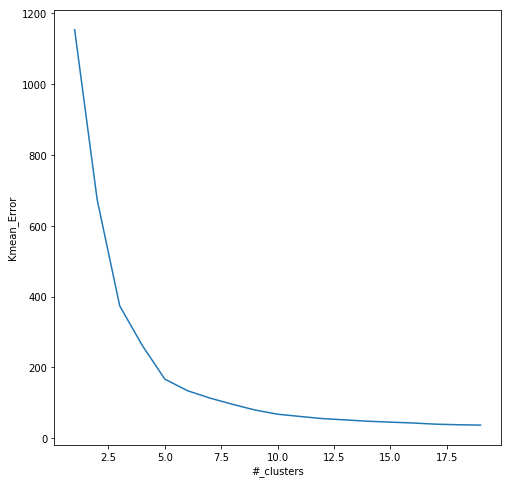

In [89]:
# determine # of clusters for Kmeans
from sklearn.cluster import KMeans
Kmean_errors = []
for i in range(1,20):
    kmeans = KMeans(init='k-means++', n_clusters=i, n_init=10)
    kmeans.fit_predict(Final_Set)
    Kmean_errors.append(kmeans.inertia_)
    
# Plot the graph
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.plot(range(1,20),Kmean_errors)
plt.xlabel('#_clusters')
plt.ylabel('Kmean_Error')
plt.show()

5 is a resonable number of clusters

Top 2 terms per cluster:


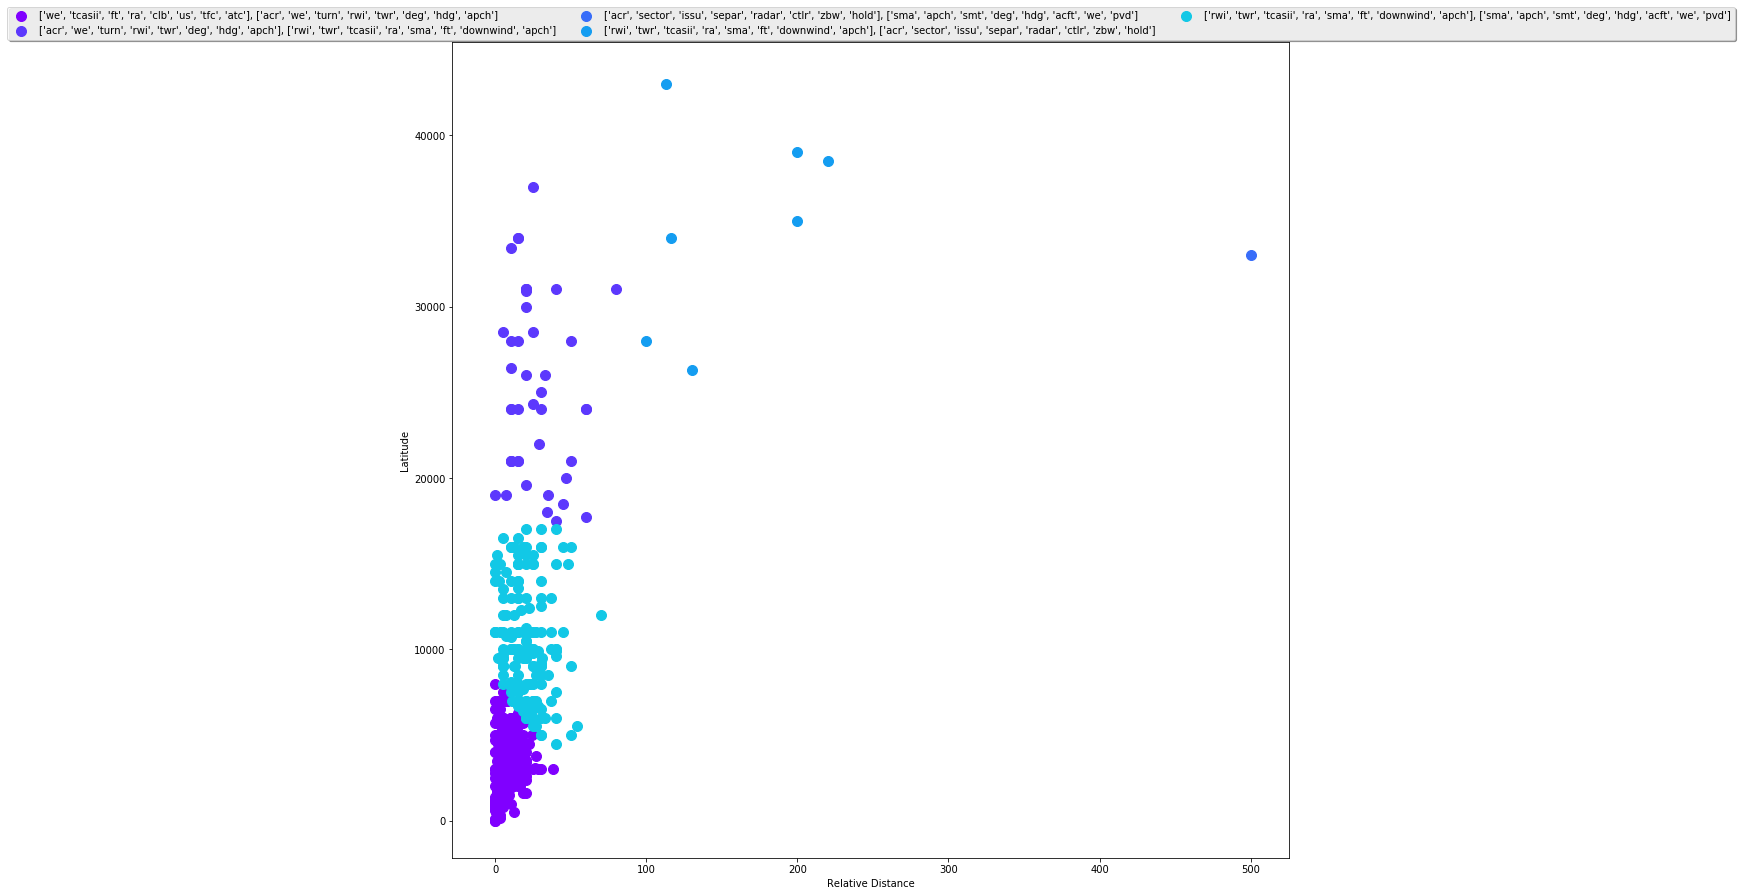

In [142]:
#Calculate Kmean
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(Final_Set)
centroids = kmeans.cluster_centers_
kmeans_Labels = kmeans.labels_
asc_order_centroids = kmeans.cluster_centers_.argsort()
order_centroids = asc_order_centroids[:,::-1]
order_centroids = order_centroids.tolist()
for i in range(len(order_centroids)):
    order_centroids[i].remove(len(Filtered_Categories))
    order_centroids[i].remove(len(Filtered_Categories) + 1)
# Store the Kmeans Cluster Labels in K_Labels
k_Labels = []
for i in range(5):
    k_Labels.append([Filtered_Categories[order_centroids[i][0]],Filtered_Categories[order_centroids[i][1]]])
    
#Plot Kmean
import matplotlib.cm as cm
print("Top 2 terms per cluster:")
#initialize plot size and colors
plt.figure(figsize=(15,15))
colors = cm.rainbow(np.linspace(0, 1, 15))
plt.xlabel('Relative Distance')
plt.ylabel('Latitude')

for i in range(len(centroids)):
    x = []
    y = []
    #find corresponding index in Final_Set for each cluster 
    for index in range(len(kmeans_Labels)):
        if kmeans_Labels[index] == i:
            x.append(Location[index][-2])
            y.append(Location[index][-1])
    plt.scatter(x, y, c=colors[i], label = (str(k_Labels[i][0]) + ', ' + str(k_Labels[i][1])), s=100)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.show()

In [143]:
# Calculate the Hierarchical with 15 clusters and Agglomerative clustering
from sklearn.cluster import AgglomerativeClustering
# Default is euclidean
H_Label = AgglomerativeClustering(n_clusters=5, linkage='ward').fit(Final_Set).labels_
H_clusternumber = 5

In [144]:
# Helper function to find centroid for Hierarchical and GMM
def find_centroid(cluster_number, Label):
    centroids = []
    for i in range(cluster_number):
        x = [[0] * len(Final_Set[0])]
        counter = 0
        #find corresponding index in Final_Set for each cluster 
        for index in range(len(Label)):
            if (Label[index] == i):
                counter += 1
                x += Final_Set[index]
        if len(x) == 0 or len(y) == 0:
            centroids.append([0,0])
        else:
            centroids.append(sum(x) / counter)
    return centroids

Hierarchical Clustering

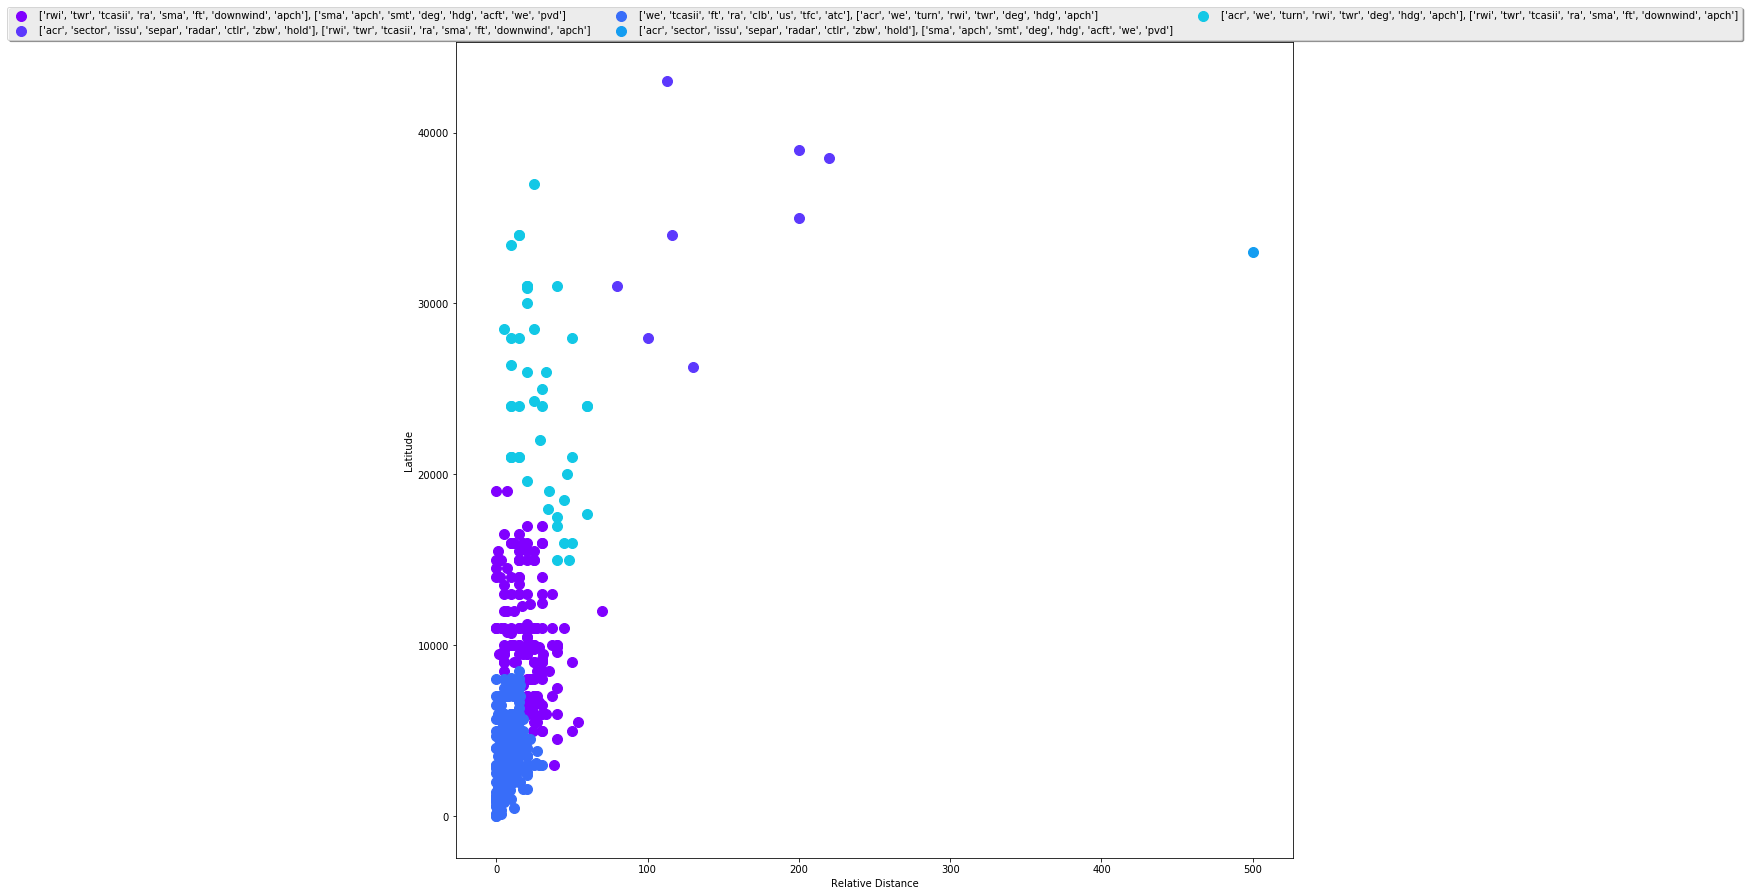

In [145]:
# Plot hierarchical
cluster_centers_ = np.array(find_centroid(5, H_Label))
asc_order_centroids = cluster_centers_.argsort()
order_centroids = asc_order_centroids[:,::-1].tolist()
for i in range(len(order_centroids)):
    order_centroids[i].remove(len(Filtered_Categories))
    order_centroids[i].remove(len(Filtered_Categories) + 1)
# Store the Hierarchical Cluster Labels in H_Labels
H_Labels = []
for i in range(5):
    H_Labels.append([Filtered_Categories[order_centroids[i][0]],Filtered_Categories[order_centroids[i][1]]])
    
plt.figure(figsize=(15,15))
colors = cm.rainbow(np.linspace(0, 1, 15))
plt.xlabel('Relative Distance')
plt.ylabel('Latitude')

for i in range(H_clusternumber):
    x = []
    y = []
    #find corresponding index in Final_Set for each cluster 
    for index in range(len(H_Label)):
        if int(H_Label[index]) == i:
            x.append(Location[index][-2])
            y.append(Location[index][-1])
    plt.scatter(x, y, c=colors[i], label = (str(H_Labels[i][0]) + ', ' + str(H_Labels[i][1])), s=100)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.show()

GMM

In [151]:
#GMM
from sklearn import mixture
g = mixture.GaussianMixture(n_components=5, covariance_type = 'spherical').fit(Final_Set)
gLabels = g.predict(Final_Set)
g_Clusternumber = 5

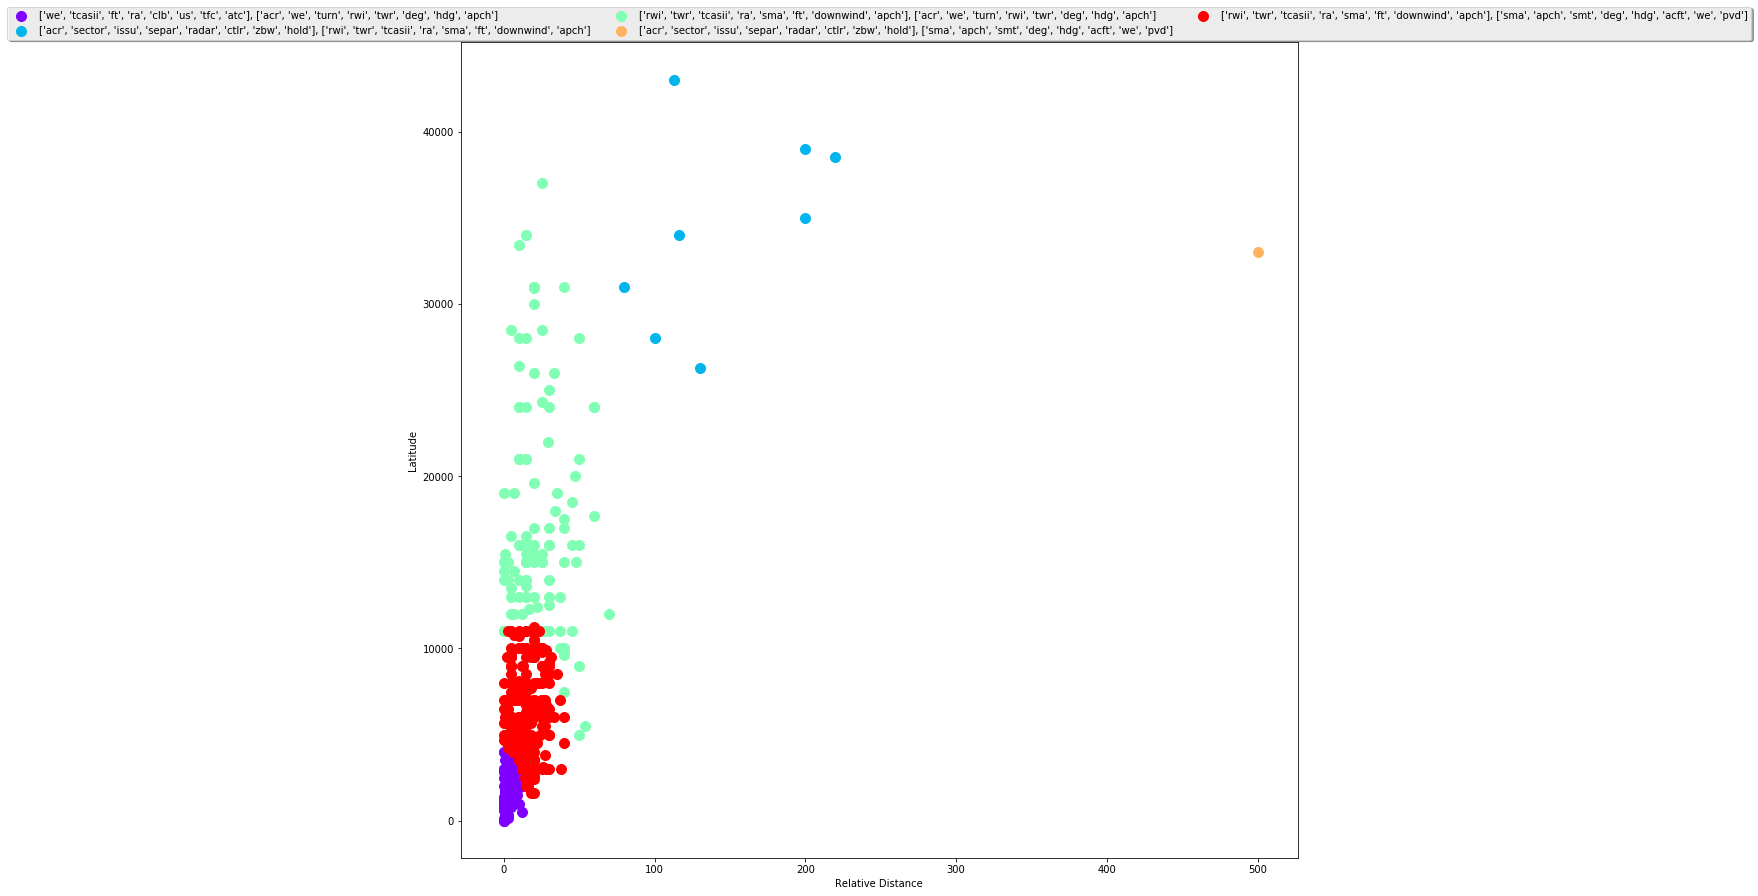

In [152]:
# Plot GMM
cluster_centers_ = np.array(find_centroid(g_Clusternumber, gLabels))
asc_order_centroids = cluster_centers_.argsort()
order_centroids = asc_order_centroids[:,::-1].tolist()
for i in range(len(order_centroids)):
    order_centroids[i].remove(len(Filtered_Categories))
    order_centroids[i].remove(len(Filtered_Categories) + 1)
    
# Store the GMM Cluster Labels in G_Labels
G_Labels = []
for i in range(g_Clusternumber):
    G_Labels.append([Filtered_Categories[order_centroids[i][0]],Filtered_Categories[order_centroids[i][1]]])
    
# Plot gmm
plt.figure(figsize=(15,15))
plt.xlabel('Relative Distance')
plt.ylabel('Latitude')
colors = cm.rainbow(np.linspace(0, 1, g_Clusternumber))

for i in range(g_Clusternumber):
    x = []
    y = []
    #find corresponding index in Final_Set for each cluster 
    for index in range(len(gLabels)):
        if gLabels[index] == i:
            x.append(Location[index][-2])
            y.append(Location[index][-1])
    plt.scatter(x, y, c=colors[i], label = (str(G_Labels[i][0]) + ', ' + str(G_Labels[i][1])), s=100)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.show()

In [97]:
#### Save Word Reference
word_reference = pd.DataFrame(word_data, columns=["before", "after"])
word_reference.head()

,before,after
0,Synopsis,synopsi
1,HELICOPTER,helicopt
2,ENCOUNTERED,encount
3,SMA,sma
4,ACFT,acft


In [136]:
# lookup dictionary word from the word reference
def lookup(word):
    for i in range(len(word_reference)):
        if word_reference['after'][i] == word:
            print(word_reference['before'][i])
            break

In [124]:
lookup('arpt')

ARPT


In [ ]:
1. midair collision sma has pattern / less than standard separation system error oppuacied
2. aircarrier error standard midair collision / in separate standard aircraft
3. nmac operator 